<a href="https://colab.research.google.com/github/vicentcamison/idal_ia3/blob/main/3%20Aprendizaje%20profundo%20(II)/Sesion%201/07_Pytorch_DL_regresion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![IDAL](https://i.imgur.com/tIKXIG1.jpg)  

#<strong>**Máster en Inteligencia Artificial Avanzada y Aplicada  IA^3**</strong>
---


##<center>**Deep learning aplicado a regresión**<center>

## Red neuronal completa, problema de regresión

En este notebook vamos a ver un ejemplo completo de aplicación de una red neuronal completa de varias capas. En concreto, combinaremos datos continuos y categóricos para realizar una regresión. El objetivo es estimar el costo de un viaje en taxi de la ciudad de Nueva York a partir de varios datos. La inspiración detrás de este código es una reciente <a href='https://www.kaggle.com/c/new-york-city-taxi-fare-prediction'>competición de kaggle</a>.

**NOTA:** En este cuaderno realizaremos una regresión con un valor de salida. En el siguiente cuaderno revisaremos el ejemplo para realizar una clasificación binaria con dos valores de salida.

En el notebook nos vamos a centrar en varios aspectos: 

*   Importación de los datos desde ficheros csv
*   Abordaje de un problema real, con diferentes tipos de variables.
*   Procesado de las variables y generación de nuevas
*   Tratamiento de variables categóricas
*   Preparación de un modelo con varias capas ocultas (_deep_)
*   Entrenamiento, validación y testeo del modelo
* Guardado del modelo
* Realización de nuevas predicciones.






## Trabajando con datos tabulares
El aprendizaje profundo con redes neuronales se asocia a menudo con el reconocimiento sofisticado de imágenes, con el fin de obtener modelos basados en propiedades como patrones de píxeles y colores. Sin embargo también es posible (y habitual) trabajar con conjuntos de datos tabulares. 
En este ejemplo trabajaremos con datos tabulares ( proceden de hojas de cálculo, tablas SQL, etc.) con columnas de valores que pueden o no ser relevantes. Como sucede, las redes neuronales pueden aprender a hacer conexiones que probablemente no hubiéramos desarrollado por nuestra cuenta. Sin embargo, para hacerlo tenemos que manejar los valores categóricos por **separado** de los continuos. 

## Importaciones standard

In [ ]:
import torch
import torch.nn as nn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

## Carga del dataset NYC Taxi Fares 

La  <a href='https://www.kaggle.com/c/new-york-city-taxi-fare-prediction'>competición de Kaggle</a> provee un conjunto de datos de cerca 55 millones de registros. Los datos solo contienen las fecha, hora, latitud, longitud de la recogida y del destino, el número de pasajeros y el coste del viaje, que es el objetivo a predecir. Queda a elección del participante obtener y emplear cualquier información adicional. Por ejemplo, ¿influye la hora del día? ¿el día de la semana? ¿como determinamos la distancia recorrida?
Para este ejercicio vamos a limitar el dataset a (solo) 120000 registros, desde el 11 al 24 de Abril de 2010. Los registros se han ordenado aleatoriamente. Vamos a ver como podemos calcular distancias desde coordenadas GPS y como preparar un dataframe de pandas con los datos que consideremos necesarios, como aprovechar la información de fecha y hora, generar nuevas variables de interés , etc.


Para cargar los datos del dataset que vamos a emplear tenemos diversas opciones. 
* Los datos originales podemos cargarlos del repositorio de Kaggle de la competición. Sin embargo son muchos datos y en el ejercicio únicamente vamos a emplear una parte de ellos. 
* Podemos cargarlos desde nuestra unidad Drive ejecutando los siguientes scripts y siguiendo las instrucciones. Para montar la unidad nos genera una clave particular que hemos de introducir. A oartir de ese momento, la estructura de carpetas de nuestro disco Drive es accesible para el Notebook dentro de /content/drive. Más detalles en la [doc de Google](https://colab.research.google.com/notebooks/io.ipynb)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/IA3_DL2_T2/NYCTaxiFares.csv')
df.head()

,pickup_datetime,fare_amount,fare_class,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2010-04-19 08:17:56 UTC,6.5,0,-73.992365,40.730521,-73.975499,40.744746,1
1,2010-04-17 15:43:53 UTC,6.9,0,-73.990078,40.740558,-73.974232,40.744114,1
2,2010-04-17 11:23:26 UTC,10.1,1,-73.994149,40.751118,-73.960064,40.766235,2
3,2010-04-11 21:25:03 UTC,8.9,0,-73.990485,40.756422,-73.971205,40.748192,1
4,2010-04-17 02:19:01 UTC,19.7,1,-73.990976,40.734202,-73.905956,40.743115,1


In [ ]:
df['fare_amount'].describe()

count    120000.000000
mean         10.040326
std           7.500134
min           2.500000
25%           5.700000
50%           7.700000
75%          11.300000
max          49.900000
Name: fare_amount, dtype: float64

Observamos qe en el conjunto del que disponemos, el rango de tarifa va de 2.50 a 49.90, con una media 10.04\$ y una mediana de 7.70\$

## Calculando la disancia recorrida

La <a href='https://en.wikipedia.org/wiki/Haversine_formula'>fórmula haversine </a> calcula la distancia en una esfera, dados dos puntos en coordenadas GPS.

Vamos a llamar a la latitud $\varphi$ (phi) y a la longitud $\lambda$ (lambda).

La formula de esta distancia es:

${\displaystyle d=2r\arcsin \left({\sqrt {\sin ^{2}\left({\frac {\varphi _{2}-\varphi _{1}}{2}}\right)+\cos(\varphi _{1})\:\cos(\varphi _{2})\:\sin ^{2}\left({\frac {\lambda _{2}-\lambda _{1}}{2}}\right)}}\right)}$

donde

$\begin{split} r&: \textrm {radio de la esfera (el radio de la Tierra es de promedio 6371 km)}\\
\varphi_1, \varphi_2&: \textrm {latitudes de punto 1 a punto 2}\\
\lambda_1, \lambda_2&: \textrm {longitudes de punto 1 a punto 2}\end{split}$

In [ ]:
def haversine_distance(df, lat1, long1, lat2, long2):
    """
    Calculo de la distancia haversine entre 2 puntos GPS
    """
    r = 6371  # radio de la Tierra en km
       
    phi1 = np.radians(df[lat1])
    phi2 = np.radians(df[lat2])
    
    delta_phi = np.radians(df[lat2]-df[lat1])
    delta_lambda = np.radians(df[long2]-df[long1])
     
    a = np.sin(delta_phi/2)**2 + np.cos(phi1) * np.cos(phi2) * np.sin(delta_lambda/2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    d = (r * c) # en km

    return d

Creamos una nueva columna con las distancias calculadas

In [ ]:
df['dist_km'] = haversine_distance(df,'pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude')
df.head()

,pickup_datetime,fare_amount,fare_class,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,dist_km
0,2010-04-19 08:17:56 UTC,6.5,0,-73.992365,40.730521,-73.975499,40.744746,1,2.126312
1,2010-04-17 15:43:53 UTC,6.9,0,-73.990078,40.740558,-73.974232,40.744114,1,1.392307
2,2010-04-17 11:23:26 UTC,10.1,1,-73.994149,40.751118,-73.960064,40.766235,2,3.326763
3,2010-04-11 21:25:03 UTC,8.9,0,-73.990485,40.756422,-73.971205,40.748192,1,1.864129
4,2010-04-17 02:19:01 UTC,19.7,1,-73.990976,40.734202,-73.905956,40.743115,1,7.231321


## Columna FechaHora y valores derivados que pueden ser útiles

La Fecha y hora nos vienen en un formato importado de texto. Pasar eso a un objete de fechahora nos permitirá extraer información como el día de la semana, momento del día am o pm, etc.

_**Nota**: Los datos están grabados en formato UTC. Teniendo en cuenta la fecha y el horario que manejan en Nueva York en ese momento, la hora correcta EDT necesita un ajuste de 4 horas menos (UTC-4)_

Generamos las nuevas columnas

In [ ]:
df['EDTdate'] = pd.to_datetime(df['pickup_datetime'].str[:19]) - pd.Timedelta(hours=4)
df['Hour'] = df['EDTdate'].dt.hour
df['AMorPM'] = np.where(df['Hour']<12,'am','pm')
df['Weekday'] = df['EDTdate'].dt.strftime("%a")
df.head()

,pickup_datetime,fare_amount,fare_class,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,dist_km,EDTdate,Hour,AMorPM,Weekday
0,2010-04-19 08:17:56 UTC,6.5,0,-73.992365,40.730521,-73.975499,40.744746,1,2.126312,2010-04-19 04:17:56,4,am,Mon
1,2010-04-17 15:43:53 UTC,6.9,0,-73.990078,40.740558,-73.974232,40.744114,1,1.392307,2010-04-17 11:43:53,11,am,Sat
2,2010-04-17 11:23:26 UTC,10.1,1,-73.994149,40.751118,-73.960064,40.766235,2,3.326763,2010-04-17 07:23:26,7,am,Sat
3,2010-04-11 21:25:03 UTC,8.9,0,-73.990485,40.756422,-73.971205,40.748192,1,1.864129,2010-04-11 17:25:03,17,pm,Sun
4,2010-04-17 02:19:01 UTC,19.7,1,-73.990976,40.734202,-73.905956,40.743115,1,7.231321,2010-04-16 22:19:01,22,pm,Fri


In [ ]:
df['EDTdate'].min()

Timestamp('2010-04-11 00:00:10')

In [ ]:
df['EDTdate'].max()

Timestamp('2010-04-24 23:59:42')

## Separamos variables categóricas y continuas



In [ ]:
df.columns

Index(['pickup_datetime', 'fare_amount', 'fare_class', 'pickup_longitude',
       'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
       'passenger_count', 'dist_km', 'EDTdate', 'Hour', 'AMorPM', 'Weekday'],
      dtype='object')

In [ ]:
cat_cols = ['Hour', 'AMorPM', 'Weekday']
cont_cols = ['pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude', 'passenger_count', 'dist_km']
y_col = ['fare_amount']  # Esta columna es el objetivo

Hemos especificado las columnas que vamos a usar de cada tipo. Observemos que **no** vamos a emplear todas. Dejamos fuera pickup_datetime y EDTdate ya que en su lugar vamos a emplear las nuevas columnas categóricas que hemos prparado</div>


## Categorizar

Panda nos permite emplear un tipo de dato <a href='https://pandas.pydata.org/pandas-docs/stable/user_guide/categorical.html'><strong>category dtype</strong></a> para convertir valores categóricos a códigos numéricos. Así, un dataset con meses del año tendrá asignados 12 códigos, uno por mes (0-11). Lo que hace pandas es sustituir las columnas por códigos y retiene una lista índice de las categorías. En los siguientes pasos llamaremos a las categorías`categories` y a su codificación `codes`

In [ ]:
for cat in cat_cols:
    df[cat] = df[cat].astype('category')

In [ ]:
df.dtypes

pickup_datetime              object
fare_amount                 float64
fare_class                    int64
pickup_longitude            float64
pickup_latitude             float64
dropoff_longitude           float64
dropoff_latitude            float64
passenger_count               int64
dist_km                     float64
EDTdate              datetime64[ns]
Hour                       category
AMorPM                     category
Weekday                    category
dtype: object

Vamos a comprobar como `df['Hour']`es ahora una variable categórica codificada:

In [ ]:
df['Hour'].head()

0     4
1    11
2     7
3    17
4    22
Name: Hour, dtype: category
Categories (24, int64): [0, 1, 2, 3, ..., 20, 21, 22, 23]

In [ ]:
df['Hour'].head().cat.codes

0     4
1    11
2     7
3    17
4    22
dtype: int8

Aquí los nombres de categoría son enteros de 0 a 23, con un total de 24 categorías. Estos valores se corresponden con los valores asignados a cada nombre.

Podemos acceder a los nombres con <tt>Series.cat.categories</tt> o a los códigos con <tt>Series.cat.codes</tt>. Vamos a verlo con <tt>df['AMorPM']</tt>:

In [ ]:
df['AMorPM'].head()

0    am
1    am
2    am
3    pm
4    pm
Name: AMorPM, dtype: category
Categories (2, object): ['am', 'pm']

In [ ]:
df['AMorPM'].cat.categories

Index(['am', 'pm'], dtype='object')

In [ ]:
df['AMorPM'].head().cat.codes

0    0
1    0
2    0
3    1
4    1
dtype: int8

In [ ]:
df['Weekday'].cat.categories

Index(['Fri', 'Mon', 'Sat', 'Sun', 'Thu', 'Tue', 'Wed'], dtype='object')

In [ ]:
df['Weekday'].head()


0    Mon
1    Sat
2    Sat
3    Sun
4    Fri
Name: Weekday, dtype: category
Categories (7, object): ['Fri', 'Mon', 'Sat', 'Sun', 'Thu', 'Tue', 'Wed']

In [ ]:
df['Weekday'].head().cat.codes

0    1
1    2
2    2
3    3
4    0
dtype: int8

**NOTA:** Observese que los días de la semana están codificados sin el orden "normal".

**NOTA2:** Los valores NaN se codifican como -1. No tenemos ninguno en ese conjunto de datos en particular. 

Ahora podemos combinar los códigos de las tres columnas categóricas en un array de entrada con la función de Numpy <a href='https://docs.scipy.org/doc/numpy/reference/generated/numpy.stack.html'><tt>numpy.stack</tt></a>. No necesitamos los índices de las categorías, solo los valores. 

In [ ]:
hr = df['Hour'].cat.codes.values
ampm = df['AMorPM'].cat.codes.values
wkdy = df['Weekday'].cat.codes.values

cats = np.stack([hr, ampm, wkdy], 1)

cats[:5]

array([[ 4,  0,  1],
       [11,  0,  2],
       [ 7,  0,  2],
       [17,  1,  3],
       [22,  1,  0]], dtype=int8)

**NOTA:** Esto se puede hacer en una sola línea empleando _list comprehension_:

`cats = np.stack([df[col].cat.codes.values for col in cat_cols], 1)`

De momento no nos preocuparemos por el tipo de datos `dtype`. Lo podremos convertir a int64 cuando pasemos el array a tensor.


## Conversión de numpy arrays a tensores

In [ ]:
# Categoricas
cats = torch.tensor(cats, dtype=torch.int64) 

cats[:5]

tensor([[ 4,  0,  1],
        [11,  0,  2],
        [ 7,  0,  2],
        [17,  1,  3],
        [22,  1,  0]])

También pasaremos las continuas a tensor para el modelo. No las vamos a normalizar aquí, dejamos ese paso para realizarlo dentro del modelo. 

**NOTA:** Por cuestiones de la normalización que realizaremos posteriormente, vamos a dejar las variables continuas como `Float (float32)` en lugar de `Double (float64)`

In [ ]:
# Continuas a tensor
conts = np.stack([df[col].values for col in cont_cols], 1)
conts = torch.tensor(conts, dtype=torch.float)
conts[:5]

tensor([[ 40.7305, -73.9924,  40.7447, -73.9755,   1.0000,   2.1263],
        [ 40.7406, -73.9901,  40.7441, -73.9742,   1.0000,   1.3923],
        [ 40.7511, -73.9941,  40.7662, -73.9601,   2.0000,   3.3268],
        [ 40.7564, -73.9905,  40.7482, -73.9712,   1.0000,   1.8641],
        [ 40.7342, -73.9910,  40.7431, -73.9060,   1.0000,   7.2313]])

In [ ]:
conts.type()

'torch.FloatTensor'

In [ ]:
# Convertimos etiquetas a tensor
y = torch.tensor(df[y_col].values, dtype=torch.float).reshape(-1,1)

y[:5]

tensor([[ 6.5000],
        [ 6.9000],
        [10.1000],
        [ 8.9000],
        [19.7000]])

Comprobamos dimensiones: 

In [ ]:
cats.shape

torch.Size([120000, 3])

In [ ]:
conts.shape

torch.Size([120000, 6])

In [ ]:
y.shape

torch.Size([120000, 1])

## Embedding para las variables categóricas

Las variables categóricas proporcionan un mejor resultado si en lugar de tratarlas como un código numérico, realizamos un proceso llamado Embedding (se traduciría como Integración/incrustación). En el embedding cada código asignado se mapea a unas variables nuevas. Esto es así porque el embedding resuelve ciertos problemas que se dan al tratar variables categóricas, que representan categorías a menudo no ordinales, pero sí relacionadas en otros aspectos.

Existen diversas formas de afrontar ese recodificado. Uno de los más simples y conocidos consiste en el OHE _One Hot Encoding_. Sin embargo, existen formas algo más evolucionadas como la que vamos a tratar en este ejercicio. 
El Embedding es una parte fundamental en el procesado de lenguaje natural, aunque su uso no se limita a dicha area. 
Encontramos [aquí](https://medium.com/@davidheffernan_99410/an-introduction-to-using-categorical-embeddings-ee686ed7e7f9) y [aquí](https://towardsdatascience.com/neural-network-embeddings-explained-4d028e6f0526) buenas explicaciones de los que es y porqué es conveniente. 

La regla del pulgar para determinar un tamaño de embedding es dividir el numero total de categorías únicas de la variable en cuestion entre 2, pero sin pasar de 50. 

In [ ]:
# Determinamos los tamaños para embedding para Hours, AMvsPM y Weekdays
cat_szs = [len(df[col].cat.categories) for col in cat_cols]
emb_szs = [(size, min(50, (size+1)//2)) for size in cat_szs]
emb_szs

[(24, 12), (2, 1), (7, 4)]

## Definimos un modelo tabular (_TabularModel_)

Este tipo de modelo está inspirado en los procedimientos de la librería <a href='https://docs.fast.ai/tabular.models.html'>fast.ai library</a>  El hecho de llamarlo modelo tabular viene de que los datos provienen de tablas, con tipos diferentes y que en mayor o menor medida se han procesado previamente. En ese preprocesado se generan o descartan variables si se considera y se hace una distinción entre variables continuas y categóricas. 
El objetivo final es definir un modelo basado en el número de variables continuas (dado por <tt>conts.shape[1]</tt>) más el número de variables categóricas y sus embeddings (dados por <tt>len(emb_szs)</tt> y <tt>emb_szs</tt> respectivamente).  La salida será una regresión (un valor único, tipo flotante), o una clasificación (un grupo de intervalos y sus valores softmax).

En este ejercicio vamos a obtener la salida de regresión, que pretende predecir la cantidad que deben pagar los usuarios por el viaje realizado. También en este ejercicio vamos a trabajas con los dos tipos de datos, continuos y categóricos. 

**Vamos a estudiar en detalle los pasos que vamos a realizar a continuación**

1. Extendemos la clase base Module indicandle los siguientes parámetros:
   * <tt>emb_szs: </tt>lista de tuplas: el tamaño de cada variable categórica (número de categorías únicas) junto con el tamaño elegido para su _embedding_
   * <tt>n_cont:  </tt>int: número de variables continuas
   * <tt>out_sz:  </tt>int: tamaño de salida
   * <tt>layers:  </tt>list of ints: tamaño de las capas intermedias que deseemos poner
   * <tt>p:       </tt>float: factor de dropout para cada capa (por simplicidad usaremos el mismo en todas las capas)

<tt><font color=black>class TabularModel(nn.Module):<br>
&nbsp;&nbsp;&nbsp;&nbsp;def \_\_init\_\_(self, emb_szs, n_cont, out_sz, layers, p=0.5):<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;super().\_\_init\_\_()</font></tt><br>

2. Generamos las capas embedded con  <a href='https://pytorch.org/docs/stable/nn.html#modulelist'><tt><strong>torch.nn.ModuleList()</strong></tt></a> y con  <a href='https://pytorch.org/docs/stable/nn.html#embedding'><tt><strong>torch.nn.Embedding()</strong></tt></a>
Los datos categóricos serán filtrados a través del Embeddings en la sección forward de la clase con el siguiente código:<br>
<tt><font color=black>&nbsp;&nbsp;&nbsp;&nbsp;self.embeds = nn.ModuleList([nn.Embedding(ni, nf) for ni,nf in emb_szs])</font></tt><br><br>
3. Incluidmos un factor dropout `p` en el embeddings con <a href='https://pytorch.org/docs/stable/nn.html#dropout'><tt><strong>torch.nn.Dropout()</strong></tt></a> Por defecto pondremos `p=0.5`<br>
<tt><font color=black>&nbsp;&nbsp;&nbsp;&nbsp;self.emb_drop = nn.Dropout(emb_drop)</font></tt><br><br>
4. Realizaremos una normalización sobre las variables continuas con <a href='https://pytorch.org/docs/stable/nn.html#batchnorm1d'><tt><strong>torch.nn.BatchNorm1d()</strong></tt></a><br>
<tt><font color=black>&nbsp;&nbsp;&nbsp;&nbsp;self.bn_cont = nn.BatchNorm1d(n_cont)</font></tt><br><br>
5. Definimos una secuencia de capas de red neuronal donde cada nivel incluirá una función lineal, una función de activación (en nuestro caso <a href='https://pytorch.org/docs/stable/nn.html#relu'><strong>ReLU</strong></a>),
un paso de normalización y un factor de dropout. Para combinar la secuencia de capas usaremos <a href='https://pytorch.org/docs/stable/nn.html#sequential'><tt><strong>torch.nn.Sequential()</strong></tt></a>. Obsérvese que este código permite especificar **tantas capas ocultas** como especifiquemos en el argumento `layers`<br>
<tt><font color=black>&nbsp;&nbsp;&nbsp;&nbsp;self.bn_cont = nn.BatchNorm1d(n_cont)<br>
&nbsp;&nbsp;&nbsp;&nbsp;layerlist = []<br>
&nbsp;&nbsp;&nbsp;&nbsp;n_emb = sum((nf for ni,nf in emb_szs))<br>
&nbsp;&nbsp;&nbsp;&nbsp;n_in = n_emb + n_cont<br>
<br>
&nbsp;&nbsp;&nbsp;&nbsp;for i in layers:<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;layerlist.append(nn.Linear(n_in,i)) <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;layerlist.append(nn.ReLU(inplace=True))<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;layerlist.append(nn.BatchNorm1d(i))<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;layerlist.append(nn.Dropout(p))<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;n_in = i<br>
&nbsp;&nbsp;&nbsp;&nbsp;layerlist.append(nn.Linear(layers[-1],out_sz))<br>
<br>
&nbsp;&nbsp;&nbsp;&nbsp;self.layers = nn.Sequential(*layerlist)</font></tt><br><br>
6. Definimos el método `forward`. En este método se realiza el preprocesado de  embeddings sobre las categóricas y la normalización sobre las continuas antes de unirlas todas y pasarlas a través de las capas. <br>Usaremos <a href='https://pytorch.org/docs/stable/torch.html#torch.cat'><tt><strong>torch.cat()</strong></tt></a> para combinar los tensores en uno.<br>
<tt><font color=black>&nbsp;&nbsp;&nbsp;&nbsp;def forward(self, x_cat, x_cont):<br>
&nbsp;&nbsp;&nbsp;&nbsp;embeddings = []<br>
&nbsp;&nbsp;&nbsp;&nbsp;for i,e in enumerate(self.embeds):<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;embeddings.append(e(x_cat[:,i]))<br>
&nbsp;&nbsp;&nbsp;&nbsp;x = torch.cat(embeddings, 1)<br>
&nbsp;&nbsp;&nbsp;&nbsp;x = self.emb_drop(x)<br>
<br>
&nbsp;&nbsp;&nbsp;&nbsp;x_cont = self.bn_cont(x_cont)<br>
&nbsp;&nbsp;&nbsp;&nbsp;x = torch.cat([x, x_cont], 1)<br>
&nbsp;&nbsp;&nbsp;&nbsp;x = self.layers(x)<br>
&nbsp;&nbsp;&nbsp;&nbsp;return x</font></tt>
</div>

### **Desglosando los pasos del Embedding** 
Las siguientes celdas de código están unicamente con fines explicativos sobre los detalles del embedding

In [ ]:
# Estos son nuestros datos origen, 
catz = cats[:4]
catz

tensor([[ 4,  0,  1],
        [11,  0,  2],
        [ 7,  0,  2],
        [17,  1,  3]])

In [ ]:
# Esto es lo que pasamos cuando el instanciamos el modelo
emb_szs

[(24, 12), (2, 1), (7, 4)]

In [ ]:
# Esto se realiza en el metodo __init__
selfembeds = nn.ModuleList([nn.Embedding(ni, nf) for ni,nf in emb_szs])
selfembeds

ModuleList(
  (0): Embedding(24, 12)
  (1): Embedding(2, 1)
  (2): Embedding(7, 4)
)

In [ ]:
list(enumerate(selfembeds))

[(0, Embedding(24, 12)), (1, Embedding(2, 1)), (2, Embedding(7, 4))]

In [ ]:
# Esto es lo que ocurre en el metodo forward()
embeddingz = []
for i,e in enumerate(selfembeds):
    embeddingz.append(e(catz[:,i]))
embeddingz

[tensor([[-0.0563,  0.4241,  1.6506, -0.5150, -0.3378,  0.9348,  0.2608, -1.0777,
          -1.5376,  0.2331, -0.7155, -1.4765],
         [-1.7659, -0.9757, -0.8239, -0.4667,  1.2974, -0.5484, -1.2628,  0.5373,
          -0.7151,  0.7899, -0.4672,  0.5213],
         [-1.1862, -0.3021, -1.3075,  1.1054,  0.8608,  0.7449, -0.0750,  0.3216,
           0.4909,  0.9544,  0.3455,  0.3916],
         [ 1.1528,  0.3192,  0.2732,  0.0737, -0.7572, -1.5875, -0.9409, -0.6160,
          -0.3653,  0.8617,  0.2217, -1.4231]], grad_fn=<EmbeddingBackward>),
 tensor([[1.8933],
         [1.8933],
         [1.8933],
         [1.0251]], grad_fn=<EmbeddingBackward>),
 tensor([[ 1.8671,  0.1844,  1.1752, -1.4316],
         [ 0.2572, -2.6230,  0.2279,  1.3817],
         [ 0.2572, -2.6230,  0.2279,  1.3817],
         [ 1.0920,  0.6097,  1.0280,  0.1129]], grad_fn=<EmbeddingBackward>)]

In [ ]:
# Concatenamos los tensores resultantes de cada variable, con dimensiones (12,1,4) en uno (17)
z = torch.cat(embeddingz, 1)
z

tensor([[-0.0563,  0.4241,  1.6506, -0.5150, -0.3378,  0.9348,  0.2608, -1.0777,
         -1.5376,  0.2331, -0.7155, -1.4765,  1.8933,  1.8671,  0.1844,  1.1752,
         -1.4316],
        [-1.7659, -0.9757, -0.8239, -0.4667,  1.2974, -0.5484, -1.2628,  0.5373,
         -0.7151,  0.7899, -0.4672,  0.5213,  1.8933,  0.2572, -2.6230,  0.2279,
          1.3817],
        [-1.1862, -0.3021, -1.3075,  1.1054,  0.8608,  0.7449, -0.0750,  0.3216,
          0.4909,  0.9544,  0.3455,  0.3916,  1.8933,  0.2572, -2.6230,  0.2279,
          1.3817],
        [ 1.1528,  0.3192,  0.2732,  0.0737, -0.7572, -1.5875, -0.9409, -0.6160,
         -0.3653,  0.8617,  0.2217, -1.4231,  1.0251,  1.0920,  0.6097,  1.0280,
          0.1129]], grad_fn=<CatBackward>)

In [ ]:
# Esto se ha definido en el metodo __init__()
selfembdrop = nn.Dropout(.4)

In [ ]:
z = selfembdrop(z)
z

tensor([[-0.0000,  0.0000,  0.0000, -0.8584, -0.5631,  1.5580,  0.4347, -0.0000,
         -0.0000,  0.0000, -1.1925, -2.4608,  0.0000,  3.1118,  0.0000,  0.0000,
         -0.0000],
        [-2.9431, -0.0000, -1.3732, -0.0000,  0.0000, -0.9140, -2.1047,  0.0000,
         -0.0000,  0.0000, -0.7786,  0.8688,  0.0000,  0.0000, -4.3717,  0.3798,
          0.0000],
        [-1.9770, -0.5036, -2.1792,  0.0000,  1.4346,  0.0000, -0.1249,  0.5360,
          0.8182,  1.5906,  0.5759,  0.6526,  3.1555,  0.4287, -0.0000,  0.3798,
          0.0000],
        [ 0.0000,  0.0000,  0.4553,  0.0000, -1.2619, -2.6458, -0.0000, -1.0267,
         -0.0000,  1.4362,  0.3695, -2.3718,  1.7085,  1.8200,  0.0000,  1.7133,
          0.1882]], grad_fn=<MulBackward0>)

**Así es como proporcionamos las variables categóricas a las capas**, concatenandolas previamente con las continuas. 

Teniendo en cuenta todo esto, esta es la definición de la clase: 

In [ ]:
class TabularModel(nn.Module):

    def __init__(self, emb_szs, n_cont, out_sz, layers, p=0.5):
        super().__init__()
        self.embeds = nn.ModuleList([nn.Embedding(ni, nf) for ni,nf in emb_szs])
        self.emb_drop = nn.Dropout(p)
        self.bn_cont = nn.BatchNorm1d(n_cont)
        
        layerlist = []
        n_emb = sum((nf for ni,nf in emb_szs))
        n_in = n_emb + n_cont
        
        for i in layers:
            layerlist.append(nn.Linear(n_in,i)) 
            layerlist.append(nn.ReLU(inplace=True))
            layerlist.append(nn.BatchNorm1d(i))
            layerlist.append(nn.Dropout(p))
            n_in = i
        layerlist.append(nn.Linear(layers[-1],out_sz))
            
        self.layers = nn.Sequential(*layerlist)
    
    def forward(self, x_cat, x_cont):
        embeddings = []
        for i,e in enumerate(self.embeds):
            embeddings.append(e(x_cat[:,i]))
        x = torch.cat(embeddings, 1)
        x = self.emb_drop(x)
        
        x_cont = self.bn_cont(x_cont)
        x = torch.cat([x, x_cont], 1)
        x = self.layers(x)
        return x

In [ ]:
torch.manual_seed(33)
model = TabularModel(emb_szs, conts.shape[1], 1, [300,100], p=0.4)

Comprobemos que la arquitectura es la correcta: 

In [ ]:
model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(24, 12)
    (1): Embedding(2, 1)
    (2): Embedding(7, 4)
  )
  (emb_drop): Dropout(p=0.4, inplace=False)
  (bn_cont): BatchNorm1d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=23, out_features=300, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.4, inplace=False)
    (4): Linear(in_features=300, out_features=100, bias=True)
    (5): ReLU(inplace=True)
    (6): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.4, inplace=False)
    (8): Linear(in_features=100, out_features=1, bias=True)
  )
)

## Definimos función de coste y optimizador
En ejercicios anteriores hemos usado la función de coste MSE. Sin embargo, resulta más interpretable (por estar en las mismas unidades que el target) emplear el RMSE. Dado que Pytorch no incorpora integrado la función <a href='https://en.wikipedia.org/wiki/Root-mean-square_deviation'>RMSE Loss</a> podemos calcularla simplemente aplicado la raiz cuadrada con <tt>torch.sqrt()</tt> al resultado de la función MSE durante el entrenamiento. 

Así pues definimos: 

In [ ]:
criterion = nn.MSELoss()  # lo convertiremos a RMSE después
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

## Preparamos conjuntos de train/test
En este punto, nuestro conjunt es un único lote de 120000 registros.  Esto llevará un tiempo de entrenamiento, por lo que podemos plantearnos reducirlo. Vamos a emplear 60000. Recordemos que los tensores ya estaban ordenados aleatoriamente.

In [ ]:
batch_size = 60000
test_size = int(batch_size * .2)

cat_train = cats[:batch_size-test_size]
cat_test = cats[batch_size-test_size:batch_size]
con_train = conts[:batch_size-test_size]
con_test = conts[batch_size-test_size:batch_size]
y_train = y[:batch_size-test_size]
y_test = y[batch_size-test_size:batch_size]

In [ ]:
len(cat_train)

48000

In [ ]:
len(cat_test)

12000

## Entrenando el modelo 

En ejercicios anteriores, el proceso de entrenamiento lo hemos definido en una función `fit` donde integramos el entrenamiento y la validación. Esto no es necesario realizarlo así siempre. Podemos simplemente realizar el bucle de entrenamiento para los epochs que queramos y después aplicar el modelo en el conjunto de test. Esta separación puede ser ineresante (o necesaria) cuando el modelo tarda mucho en la fase de entrenamiento. 

Es posible que nuestro modelo  tarde 30 min o más. Añadimos algunas líneas de código para observar al final la duración.


In [ ]:
import time
start_time = time.time()

epochs = 300
losses = []

for i in range(epochs):
    i+=1

    y_pred = model(cat_train, con_train)
    loss = torch.sqrt(criterion(y_pred, y_train)) # RMSE
    losses.append(loss)
    
    # Mostramos en pantalla cada 25 epochs:
    if i%25 == 1:
        print(f'epoch: {i:3}  loss: {loss.item():10.8f}')

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

print(f'epoch: {i:3}  loss: {loss.item():10.8f}') # print the last line
print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed

epoch:   1  loss: 12.55656242
epoch:  26  loss: 10.71524811
epoch:  51  loss: 10.11211967
epoch:  76  loss: 9.67676449
epoch: 101  loss: 9.16138649
epoch: 126  loss: 8.42829990
epoch: 151  loss: 7.44493628
epoch: 176  loss: 6.30381441
epoch: 201  loss: 5.12436295
epoch: 226  loss: 4.17876339
epoch: 251  loss: 3.81657648
epoch: 276  loss: 3.74913311
epoch: 300  loss: 3.64693809

Duration: 544 seconds


## Visualizamos la función de error 

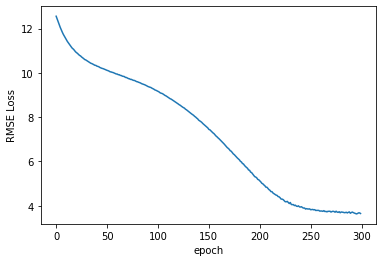

In [ ]:
plt.plot(range(epochs), losses)
plt.ylabel('RMSE Loss')
plt.xlabel('epoch');

## Validamos el modelo
Ahora vamos a lanzar el modelo con el conjunto de test y a comparar los resultados con las etiquetas conocidas. 

Dado que en este paso no es necesario actualizar pesos ni biases, no es necesario emplear la función autograd, por lo que ponemos <tt>torch.no_grad()</tt> y evitamos cálculos (y tiempo ) innecesario.

In [ ]:
# (método validation_step en el ejemplo anterior)
with torch.no_grad():
    y_val = model(cat_test, con_test)
    loss = torch.sqrt(criterion(y_val, y_test))
print(f'RMSE: {loss:.8f}')

RMSE: 3.58658552


Esto quiere decir que como promedio, los valores predichos por el modelo difieren &plusmn;$3.58 del valor real.

Observemos los primeros 50 valores y sus diferencias:

In [ ]:
print(f'{"PREDICTED":>12} {"ACTUAL":>8} {"DIFF":>8}')
for i in range(50):
    diff = np.abs(y_val[i].item()-y_test[i].item())
    print(f'{i+1:2}. {y_val[i].item():8.4f} {y_test[i].item():8.4f} {diff:8.4f}')

   PREDICTED   ACTUAL     DIFF
 1.   3.3897   2.9000   0.4897
 2.  21.4156   5.7000  15.7156
 3.   6.8739   7.7000   0.8261
 4.  14.0987  12.5000   1.5987
 5.   4.9695   4.1000   0.8695
 6.   2.9566   5.3000   2.3434
 7.   4.9119   3.7000   1.2119
 8.  12.5546  14.5000   1.9454
 9.   4.2339   5.7000   1.4661
10.  10.8443  10.1000   0.7443
11.   3.7450   4.5000   0.7550
12.   6.6382   6.1000   0.5382
13.   6.3354   6.9000   0.5646
14.   9.8351  14.1000   4.2649
15.   6.4549   4.5000   1.9549
16.  30.5704  34.1000   3.5296
17.   3.6908  12.5000   8.8092
18.   5.0881   4.1000   0.9881
19.   8.7589   8.5000   0.2589
20.   7.1429   5.3000   1.8429
21.  14.3821  11.3000   3.0821
22.  12.9264  10.5000   2.4264
23.  16.1893  15.3000   0.8893
24.  15.7248  14.9000   0.8248
25.  56.2197  49.5700   6.6497
26.   2.7321   5.3000   2.5679
27.   6.2285   3.7000   2.5285
28.   8.4603   6.5000   1.9603
29.  15.0007  14.1000   0.9007
30.   3.3144   4.9000   1.5856
31.   5.7993   3.7000   2.0993
32.  40.

Como podemos ver, mientras algunas predicciones apenas difieren en unos céntimos, otras llegan a más de \\$15.00 de dferencia. Prueba a cambiar parámetros como el tamaño de lote, de test, el número de ciclos, la tasa de aprendizaje, etc. con el fin de conseguir un modelo mejor. 

## Guardando el modelo the model
Recordemos que podemos salvar un modelo entrenado como un fichero en disco de forma que podamos recuperarlo posterormente para realizar predicciones o continuar entrenandolo con más datos. 
Habitualmente lo que suele hacerse es salvar las matrices de pesos y biases y no toda la definición. Podemos encontrar más información sobre el proceso de guardado y sus recomendaciones en  <a href='https://pytorch.org/tutorials/beginner/saving_loading_models.html'>https://pytorch.org/tutorials/beginner/saving_loading_models.html</a>

In [ ]:
# Aseguramos que lo guardao SOLO depués de haberlo entrenado!
if len(losses) == epochs:
    torch.save(model.state_dict(), 'TaxiFareRegrModel.pt')
else:
    print('Model has not been trained. Consider loading a trained model instead.')

## Cargando el modelo (empezando de cero)
Ahora podemos cargar el fichero con pesos y biases de nuestro modelo guardado. 
Si acabamos de iniciar el Notebook, tendremos que lanzar las funciones de importación de módulos y sobretodo, las definiciones de funciones y clases. 

Para ilustrar esto reinicia  el Kernel antes de continuar. 

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd

def haversine_distance(df, lat1, long1, lat2, long2):
    r = 6371
    phi1 = np.radians(df[lat1])
    phi2 = np.radians(df[lat2])
    delta_phi = np.radians(df[lat2]-df[lat1])
    delta_lambda = np.radians(df[long2]-df[long1])
    a = np.sin(delta_phi/2)**2 + np.cos(phi1) * np.cos(phi2) * np.sin(delta_lambda/2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    return r * c

class TabularModel(nn.Module):
    def __init__(self, emb_szs, n_cont, out_sz, layers, p=0.5):
        super().__init__()
        self.embeds = nn.ModuleList([nn.Embedding(ni, nf) for ni,nf in emb_szs])
        self.emb_drop = nn.Dropout(p)
        self.bn_cont = nn.BatchNorm1d(n_cont)
        layerlist = []
        n_emb = sum((nf for ni,nf in emb_szs))
        n_in = n_emb + n_cont
        for i in layers:
            layerlist.append(nn.Linear(n_in,i)) 
            layerlist.append(nn.ReLU(inplace=True))
            layerlist.append(nn.BatchNorm1d(i))
            layerlist.append(nn.Dropout(p))
            n_in = i
        layerlist.append(nn.Linear(layers[-1],out_sz))
        self.layers = nn.Sequential(*layerlist)
    def forward(self, x_cat, x_cont):
        embeddings = []
        for i,e in enumerate(self.embeds):
            embeddings.append(e(x_cat[:,i]))
        x = torch.cat(embeddings, 1)
        x = self.emb_drop(x)
        x_cont = self.bn_cont(x_cont)
        x = torch.cat([x, x_cont], 1)
        return self.layers(x)

Hemos definido las importaciones, funciones y clases. Ahora, antes de cargar los valores salvados, tenemos que instanciar nuestro modelo TabularModel con los mismos parámetros que antes (tamaños de embedding, número de columnas continuas, tamaño de salida, tamaño de capas y factor de dropout). 

In [ ]:
emb_szs = [(24, 12), (2, 1), (7, 4)]
model2 = TabularModel(emb_szs, 6, 1, [300,100], p=0.4)

Once the model is set up, loading the saved settings is a snap.

In [ ]:
model2.load_state_dict(torch.load('/content/TaxiFareRegrModel.pt'));
model2.eval() # No olvides realizar este paso

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(24, 12)
    (1): Embedding(2, 1)
    (2): Embedding(7, 4)
  )
  (emb_drop): Dropout(p=0.4, inplace=False)
  (bn_cont): BatchNorm1d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=23, out_features=300, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.4, inplace=False)
    (4): Linear(in_features=300, out_features=100, bias=True)
    (5): ReLU(inplace=True)
    (6): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.4, inplace=False)
    (8): Linear(in_features=100, out_features=1, bias=True)
  )
)


Ahora podemos definir una función que solicite los datos de entrada al usuario , realice todos los pasos de preprocesado definidos al principio del Notebook y los pase al modelo entrenado con el fin de obtener una predicción concreta. 

In [ ]:
def test_data(mdl): # nombre del modelo que hemos instanciado
    # Nuevos datos:
    plat = float(input('Latitud de recogida: '))
    plong = float(input('Longitud de recogida: '))
    dlat = float(input('Latitud de entrega:  '))
    dlong = float(input('Longitud de entrega: '))
    psngr = int(input('Número de pasajeros '))
    dt = input('Especifica la fecha y hora en formato YYYY-MM-DD HH:MM:SS     ')
    
    # Preprocesado de lso datos:
    dfx_dict = {'pickup_latitude':plat,'pickup_longitude':plong,'dropoff_latitude':dlat,
         'dropoff_longitude':dlong,'passenger_count':psngr,'EDTdate':dt}
    dfx = pd.DataFrame(dfx_dict, index=[0])
    dfx['dist_km'] = haversine_distance(dfx,'pickup_latitude', 'pickup_longitude',
                                        'dropoff_latitude', 'dropoff_longitude')
    dfx['EDTdate'] = pd.to_datetime(dfx['EDTdate'])
    
    # Recodificamos las categoricas:
    dfx['Hour'] = dfx['EDTdate'].dt.hour
    dfx['AMorPM'] = np.where(dfx['Hour']<12,0,1) 
    dfx['Weekday'] = dfx['EDTdate'].dt.strftime("%a")
    dfx['Weekday'] = dfx['Weekday'].replace(['Fri','Mon','Sat','Sun','Thu','Tue','Wed'],
                                            [0,1,2,3,4,5,6]).astype('int64')
    # Creamos y concatenamos tensores
    cat_cols = ['Hour', 'AMorPM', 'Weekday']
    cont_cols = ['pickup_latitude', 'pickup_longitude', 'dropoff_latitude',
                 'dropoff_longitude', 'passenger_count', 'dist_km']
    xcats = np.stack([dfx[col].values for col in cat_cols], 1)
    xcats = torch.tensor(xcats, dtype=torch.int64)
    xconts = np.stack([dfx[col].values for col in cont_cols], 1)
    xconts = torch.tensor(xconts, dtype=torch.float)
    
    # Pasamos los nuevos datos al modelo. Sin backpropagacion
    with torch.no_grad():
        z = mdl(xcats, xconts)
    print(f'\nLa cantidad resultante es ${z.item():.2f}')

## Introduciendo nuevos datos a través del modelo

Como referencia, estos son los valores máximos y mínimos de las variables solicitadas:
<table style="display: inline-block">
<tr><th>Column</th><th>Mínimo</th><th>Máximo</th></tr>
<tr><td>pickup_latitude</td><td>40</td><td>41</td></tr>
<tr><td>pickup_longitude</td><td>-74.5</td><td>-73.3</td></tr>
<tr><td>dropoff_latitude</td><td>40</td><td>41</td></tr>
<tr><td>dropoff_longitude</td><td>-74.5</td><td>-73.3</td></tr>
<tr><td>passenger_count</td><td>1</td><td>5</td></tr>
<tr><td>EDTdate</td><td>2010-04-11 00:00:00</td><td>2010-04-24 23:59:42</td></tr>

<strong>ATENCION!</strong> La distancia entre 1 grado de latitud (40 a 41) is 111km y en q grade de longitud (-73 a -74) is 85km. El viaje más largo en el dataset muestra una diferencia de solo 0.243 grados lat. y  0.284 de long. La iferencia media para ambos está en torno a 0.02. Para obtener una buena predicción hay que emplear valores cercanos. 

In [ ]:
z = test_data(model2)

## Fin del Notebook

Referencias y modelos empleados para el Notebook: 

*   Documentación de [Pytorch](https://pytorch.org/docs/stable/index.html) 
*   [PyTorch Tutorial for Deep Learning Researchers](https://github.com/yunjey/pytorch-tutorial) by Yunjey Choi
*   [FastAI](https://www.fast.ai/) development notebooks by Jeremy Howard.
*   Documentación y cursos en [Pierian Data](https://www.pieriandata.com/)
*   Tutoriales y notebooks del curso "Deep Learning with Pytorch: Zero to GANs" de [Aakash N S](https://jovian.ai/aakashns)
* [A visual proof that neural networks can compute any function](http://neuralnetworksanddeeplearning.com/chap4.html), también conocido como Teorema de Aproximación Universal
* [But what *is* a neural network?](https://www.youtube.com/watch?v=aircAruvnKk) - Una introducción muy intuitiva a lo que son las redes neuronales y lo que implican las capas ocultas.